In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class

from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [31]:
backtest_start_date = datetime(2016,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [72]:
portfolio = APortfolio(pricer_list.QUARTERLY_STOCK_FINANCIAL
                       ,classifier_list.QUARTERLY_STOCK_FINANCIAL_CLASSIFIER
                       ,ranker_list.QUARTERLY_STOCK_EARNINGS_RANKER)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iv = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolios = []
# portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)
portfolios.append(portfolio_iv)
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
fund.initialize_portfolios()

In [73]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [74]:
tyields = returns_products_class.tyields()
bench_returns = returns_products_class.spy_bench()

In [75]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("historical_trades")
    trade["positions"] = portfolio.pricer_class.positions
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [76]:
t = pd.concat(trades)
t = t[t["year"]>=backtest_start_date.year]

In [77]:
t

,year,week,ticker,weekly_delta,weekly_delta_sign,short_returns,returns,position,actual_returns,value,ceiling,classification,rank,short,market_return,positions,portfolio,pricer_timeframe
0,2016,34,VZ,0.023028,-1.0,1.002835,0.997165,0,1.002835,True,True,True,True,True,1.15,20,wss_wssc_wsrr_b_r,week
1,2016,49,LEN,0.024748,1.0,0.995172,0.995172,0,0.995172,True,True,True,True,True,1.15,20,wss_wssc_wsrr_b_r,week
2,2017,5,HES,0.045490,-1.0,1.023270,0.976730,0,1.023270,True,True,True,True,True,1.15,20,wss_wssc_wsrr_b_r,week
3,2017,9,CTRA,0.016893,-1.0,0.986822,1.013178,0,0.986822,True,True,True,True,True,1.15,20,wss_wssc_wsrr_b_r,week
4,2017,11,KMI,0.022636,-1.0,1.011007,0.988993,0,1.011007,True,True,True,True,True,1.15,20,wss_wssc_wsrr_b_r,week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289353,2022,48,MDT,0.053902,1.0,0.992757,0.992757,19,0.992757,False,False,False,False,False,2.00,20,wsw_wssc_wsrr_b_r,week
289354,2022,49,TFC,0.100257,1.0,1.005624,1.005624,19,1.005624,False,False,False,False,False,2.00,20,wsw_wssc_wsrr_b_r,week
289355,2022,50,COST,0.089217,1.0,0.976420,0.976420,19,0.976420,False,False,False,False,False,2.00,20,wsw_wssc_wsrr_b_r,week
289356,2022,51,VRTX,0.083312,1.0,0.990405,0.990405,19,0.990405,False,False,False,False,False,2.00,20,wsw_wssc_wsrr_b_r,week


In [78]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [79]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [80]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'portfolio',
 'pricer_timeframe']

In [81]:
analysis = []
for parameter in parameters:
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(ledger["positions"].mean())
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [82]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
343,True,True,False,False,False,1.15,wsw_wssc_wsrr_b_r,week,9.169065,-0.040068,0.959518,-203.857149
343,True,False,False,False,False,1.15,wsw_wssc_wsrr_b_r,week,9.169065,-0.040068,0.959518,-203.857149
343,True,False,False,False,False,2.00,wsw_wssc_wsrr_b_r,week,9.150864,-0.039134,0.960483,-208.256040
343,True,True,False,False,False,2.00,wsw_wssc_wsrr_b_r,week,9.150864,-0.039134,0.960483,-208.256040
343,True,False,False,False,False,1.50,wsw_wssc_wsrr_b_r,week,9.143994,-0.039134,0.960483,-208.079171
343,True,True,False,False,False,1.50,wsw_wssc_wsrr_b_r,week,9.143994,-0.039134,0.960483,-208.079171
342,True,True,False,False,False,1.50,wss_wssc_wsrr_b_r,week,8.998984,-0.039068,0.960552,-204.719945
342,True,False,False,False,False,1.50,wss_wssc_wsrr_b_r,week,8.998984,-0.039068,0.960552,-204.719945
342,True,False,False,False,False,1.15,wss_wssc_wsrr_b_r,week,8.971565,-0.039763,0.959833,-200.452069
342,True,True,False,False,False,1.15,wss_wssc_wsrr_b_r,week,8.971565,-0.039763,0.959833,-200.452069


In [83]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,pricer_timeframe,pv,beta,rrr,sharpe
0,wsr_wssc_wsrr_b_r,True,True,False,False,False,2.00,week,4.697982,-0.058160,0.940804,-63.566471
1,wss_wssc_wsrr_b_r,True,True,False,False,False,1.50,week,8.998984,-0.039068,0.960552,-204.719945
2,wsw_wssc_wsrr_b_r,True,True,False,False,False,1.15,week,9.169065,-0.040068,0.959518,-203.857149


In [84]:
top = a[a["portfolio"]=="wss_wssc_wsrr_b_r"].sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

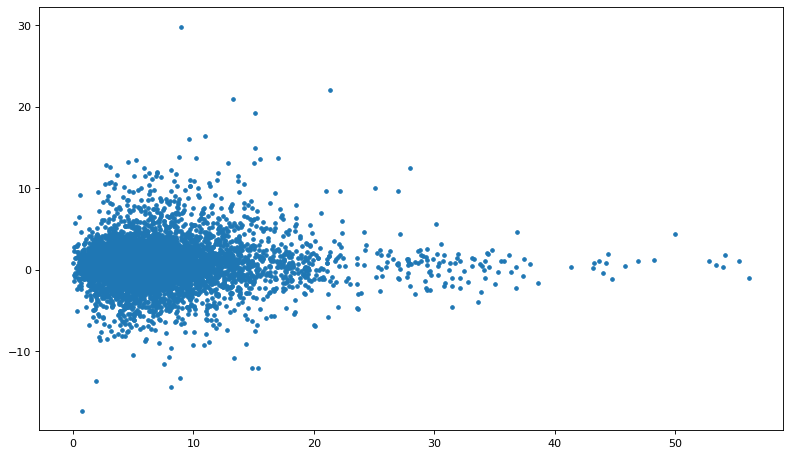

In [85]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [86]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2016,4,KMI,0.220506,1.0,1.030941,0,Energy,Kinder Morgan
343,2016,4,UAA,0.183527,1.0,0.946082,1,Consumer Discretionary,Under Armour (Class A)
684,2016,4,NVR,0.179473,1.0,0.980081,2,Consumer Discretionary,"NVR, Inc."
1025,2016,4,NEM,0.170249,1.0,1.137713,3,Materials,Newmont
1366,2016,4,META,0.140046,1.0,0.960031,4,Communication Services,Meta Platforms
1706,2016,4,SLB,0.133565,1.0,0.987126,5,Energy,Schlumberger
2044,2016,4,TPR,0.130839,1.0,0.969901,6,Consumer Discretionary,"Tapestry, Inc."
2382,2016,4,OKE,0.122661,1.0,1.087457,7,Energy,Oneok
2718,2016,4,EOG,0.120619,1.0,0.990592,8,Energy,EOG Resources
3053,2016,4,SEDG,0.118535,1.0,1.033952,9,Information Technology,SolarEdge


In [87]:
ledger["actual_returns"].mean()

1.006673402689797

In [88]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.6312490673033876

In [89]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [90]:
portfolio

position,year,week,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2016,4,1.030941,0.946082,0.980081,1.137713,0.960031,0.987126,0.969901,1.087457,...,1.002427,0.952829,0.963286,1.018192,1.006310,1.019186,1.049393,0.969989,1.040948,1.004701
1,2016,5,1.001397,0.996902,0.992941,0.976241,0.955297,0.992246,0.988925,1.004233,...,0.994200,1.012810,0.994236,1.002148,0.976350,0.924260,0.997939,1.004362,1.003402,1.013540
2,2016,6,1.023344,1.014938,1.085774,1.023201,1.105255,1.016026,1.019773,0.986387,...,1.035798,1.044063,1.016758,0.993463,1.015196,1.026069,1.005016,1.003781,0.999862,1.012234
3,2016,7,1.020137,1.018165,0.999182,0.985796,1.036891,0.969361,0.996227,1.034025,...,0.991307,0.989456,1.021885,1.009875,1.014996,0.989242,1.041974,1.037113,1.018583,1.012894
4,2016,8,1.025155,1.022123,1.003707,0.999404,1.008091,1.042810,1.027283,1.012768,...,1.023451,1.021357,1.021225,1.033033,1.001375,1.013466,1.013288,0.991617,1.030635,0.989400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2022,48,1.003763,1.044122,0.985901,1.019786,0.998926,1.004094,1.021503,0.981862,...,0.988058,1.014802,0.997558,1.012656,0.992422,0.980789,0.961484,0.956403,0.995868,0.995504
339,2022,49,1.012846,0.989698,1.013725,1.001157,0.993173,1.007533,1.053633,1.002606,...,1.000960,1.003770,1.016176,0.993362,1.014723,1.022673,1.021833,0.981168,1.019785,1.007757
340,2022,50,0.987461,0.960084,1.008340,0.997648,0.984544,0.937786,0.989064,0.989299,...,0.966137,0.944987,0.987449,0.983011,0.987898,0.989149,0.975812,0.978548,0.988716,0.988799
341,2022,51,0.991848,1.001887,1.007790,1.003804,1.009723,0.918000,0.995214,0.994816,...,1.004693,1.007517,1.014348,1.004389,1.009945,1.011363,1.016487,1.012391,1.005206,0.989545


In [91]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [92]:
cumulative

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,1.030941,0.946082,0.980081,1.137713,0.960031,0.987126,0.969901,1.087457,0.990592,1.033952,...,0.969989,1.040948,1.004701,2016,4,1.007557,187.73000,1.000000,2016-W4,2016-01-29
1,1.032382,0.943151,0.973163,1.110682,0.917115,0.979472,0.959159,1.092060,0.996795,1.038073,...,0.974220,1.044489,1.018305,2016,5,0.999528,189.76016,1.010814,2016-W5,2016-02-05
2,1.056482,0.957240,1.056635,1.136450,1.013646,0.995169,0.978125,1.077194,1.004852,1.055740,...,0.977903,1.044345,1.030763,2016,6,1.021418,190.93200,1.017056,2016-W6,2016-02-12
3,1.077756,0.974628,1.055771,1.120309,1.051041,0.964678,0.974434,1.113846,0.988853,1.110857,...,1.014196,1.063753,1.044054,2016,7,1.032922,185.12200,0.986108,2016-W7,2016-02-19
4,1.104867,0.996190,1.059685,1.119641,1.059545,1.005976,1.001019,1.128067,1.008946,1.090828,...,1.005693,1.096341,1.032987,2016,8,1.047156,191.68750,1.021081,2016-W8,2016-02-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,11.026190,14.355034,15.451528,8.022030,10.395380,14.327080,11.472194,9.502510,10.140156,2.639579,...,3.733766,4.545822,7.816363,2022,48,8.860590,399.81000,2.129708,2022-W48,2022-12-02
339,11.167829,14.207151,15.663606,8.031312,10.324412,14.435004,12.087481,9.527275,10.566240,2.660500,...,3.663451,4.635760,7.876995,2022,49,8.958265,402.62200,2.144687,2022-W49,2022-12-09
340,11.027791,13.640059,15.794245,8.012420,10.164833,13.536945,11.955296,9.425323,10.556205,2.544910,...,3.584863,4.583448,7.788765,2022,50,8.780397,395.22000,2.105258,2022-W50,2022-12-16
341,10.937893,13.665800,15.917277,8.042903,10.263667,12.426921,11.898074,9.376465,10.614583,2.537053,...,3.629284,4.607309,7.707333,2022,51,8.757179,394.64400,2.102189,2022-W51,2022-12-23


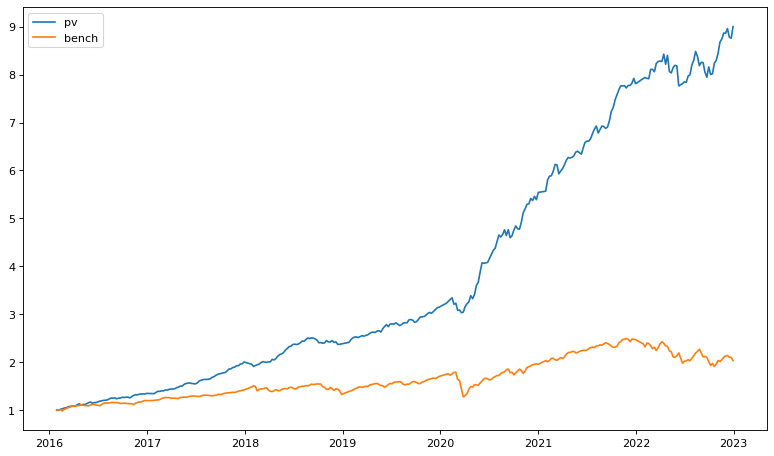

In [93]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [94]:
cumulative

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,1.030941,0.946082,0.980081,1.137713,0.960031,0.987126,0.969901,1.087457,0.990592,1.033952,...,0.969989,1.040948,1.004701,2016,4,1.007557,187.73000,1.000000,2016-W4,2016-01-29
1,1.032382,0.943151,0.973163,1.110682,0.917115,0.979472,0.959159,1.092060,0.996795,1.038073,...,0.974220,1.044489,1.018305,2016,5,0.999528,189.76016,1.010814,2016-W5,2016-02-05
2,1.056482,0.957240,1.056635,1.136450,1.013646,0.995169,0.978125,1.077194,1.004852,1.055740,...,0.977903,1.044345,1.030763,2016,6,1.021418,190.93200,1.017056,2016-W6,2016-02-12
3,1.077756,0.974628,1.055771,1.120309,1.051041,0.964678,0.974434,1.113846,0.988853,1.110857,...,1.014196,1.063753,1.044054,2016,7,1.032922,185.12200,0.986108,2016-W7,2016-02-19
4,1.104867,0.996190,1.059685,1.119641,1.059545,1.005976,1.001019,1.128067,1.008946,1.090828,...,1.005693,1.096341,1.032987,2016,8,1.047156,191.68750,1.021081,2016-W8,2016-02-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,11.026190,14.355034,15.451528,8.022030,10.395380,14.327080,11.472194,9.502510,10.140156,2.639579,...,3.733766,4.545822,7.816363,2022,48,8.860590,399.81000,2.129708,2022-W48,2022-12-02
339,11.167829,14.207151,15.663606,8.031312,10.324412,14.435004,12.087481,9.527275,10.566240,2.660500,...,3.663451,4.635760,7.876995,2022,49,8.958265,402.62200,2.144687,2022-W49,2022-12-09
340,11.027791,13.640059,15.794245,8.012420,10.164833,13.536945,11.955296,9.425323,10.556205,2.544910,...,3.584863,4.583448,7.788765,2022,50,8.780397,395.22000,2.105258,2022-W50,2022-12-16
341,10.937893,13.665800,15.917277,8.042903,10.263667,12.426921,11.898074,9.376465,10.614583,2.537053,...,3.629284,4.607309,7.707333,2022,51,8.757179,394.64400,2.102189,2022-W51,2022-12-23


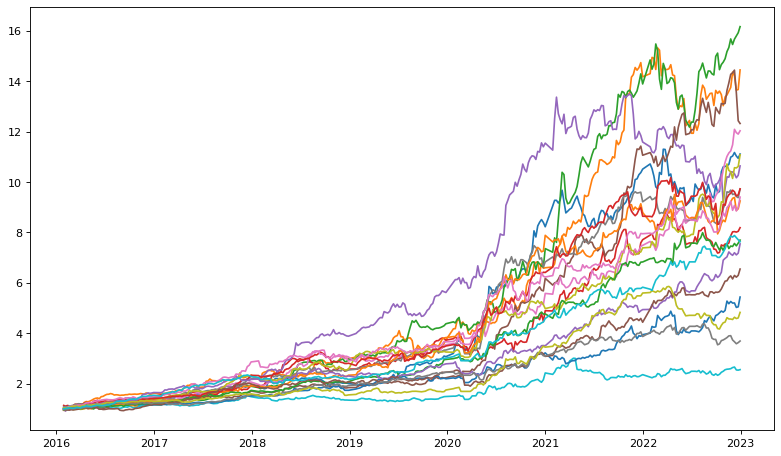

In [95]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [96]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Information Technology,2018.821764,27.188555,0.069588,1.0,1.008815,9.385553
Health Care,2019.216649,28.235859,0.065334,1.0,1.008230,9.486660
Industrials,2018.870647,26.570481,0.060627,1.0,1.007586,10.784411
Communication Services,2019.038147,28.073569,0.064902,1.0,1.007568,9.694823
Materials,2019.003268,26.901961,0.065581,1.0,1.007403,9.692810
Consumer Discretionary,2018.911095,29.529758,0.106269,1.0,1.006278,6.758266
Energy,2019.151242,26.293454,0.070258,1.0,1.005378,9.650113
Financials,2019.038674,29.718232,0.060511,1.0,1.004989,11.213628
Real Estate,2018.665730,28.233146,0.049362,1.0,1.004720,11.053371


In [97]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  weekly_delta_sign  \
year week ticker Security                                                   
2020 20   PENN   Penn National Gaming         0.090039                1.0   
     23   AAL    American Airlines Group      0.213353                1.0   
2019 4    AMD    AMD                          0.132793                1.0   
2020 16   MRNA   Moderna                      0.151309                1.0   
     27   TSLA   Tesla, Inc.                  0.109471                1.0   
     19   MRNA   Moderna                      0.096128                1.0   
     32   PENN   Penn National Gaming         0.151065                1.0   
          MGM    MGM Resorts                  0.088212                1.0   
2016 4    NEM    Newmont                      0.170249                1.0   
2018 24   ETSY   Etsy                         0.101928                1.0   
2020 22   SPG    Simon Property Group         0.155010                1.0   
2018 9    ENPH   Enphase                      0.052082                1.0   
     6    TWTR   Twitter Inc.                 0.045364                1.0   
2020 43   ALGN   Align Technology             0.128509                1.0   
2017 28   NRG    NRG Energy                   0.150599                1.0   
2022 17   WDC    Western Digital              0.027602                1.0   
          MHK    Mohawk Industries            0.030390                1.0   
2020 21   PENN   Penn National Gaming         0.280007                1.0   
     53   APA    APA Corporation              0.059276                1.0   
2021 7    AAL    American Airlines Group      0.081001                1.0   
2020 37   PENN   Penn National Gaming         0.069726                1.0   
     22   KIM    Kimco Realty                 0.120490                1.0   
2018 31   DXCM   Dexcom                       0.063384                1.0   
2020 4    ENPH   Enphase                      0.069999                1.0   
     45   ALB    Albemarle Corporation        0.085221                1.0   
2022 4    TMUS   T-Mobile US                  0.036380                1.0   
2021 43   UAA    Under Armour (Class A)       0.068864                1.0   
2020 23   BA     Boeing                       0.136958                1.0   
2021 30   MRNA   Moderna                      0.050853                1.0   
2016 39   NXPI   NXP Semiconductors           0.060067                1.0   

                                          actual_returns  position  
year week ticker Security                                           
2020 20   PENN   Penn National Gaming           1.298529         7  
     23   AAL    American Airlines Group        1.220762         0  
2019 4    AMD    AMD                            1.209613         8  
2020 16   MRNA   Moderna                        1.192656         0  
     27   TSLA   Tesla, Inc.                    1.164547         5  
     19   MRNA   Moderna                        1.160974        11  
     32   PENN   Penn National Gaming           1.149030         4  
          MGM    MGM Resorts                    1.138746        18  
2016 4    NEM    Newmont                        1.137713         3  
2018 24   ETSY   Etsy                           1.136682         4  
2020 22   SPG    Simon Property Group           1.136366         5  
2018 9    ENPH   Enphase                        1.134885         0  
     6    TWTR   Twitter Inc.                   1.132719         1  
2020 43   ALGN   Align Technology               1.131492         1  
2017 28   NRG    NRG Energy                     1.130423         1  
2022 17   WDC    Western Digital                1.128036        12  
          MHK    Mohawk Industries              1.125756        11  
2020 21   PENN   Penn National Gaming           1.124965         0  
     53   APA    APA Corporation                1.124874         9  
2021 7    AAL    American Airlines Group        1.122850         2  
2020 37   PENN   Penn National Gaming           1.119838   

In [98]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2016,4,0.960031,0.963776,1.000000,1.023223,0.963286,1.000000,1.024096,1.018189,1.137713,1.000000,1.000000
1,4064256,20,0.960031,0.963776,0.992941,1.023223,0.963286,0.976241,1.024096,1.015035,1.119571,0.950305,1.000529
2,8193540096,120,0.964846,1.006244,1.014385,1.043455,0.984252,0.984132,1.043698,1.111986,1.137604,0.950305,0.996400
3,16518176833536,840,0.964846,1.000348,1.014385,1.043455,0.984252,0.992112,1.077079,1.121497,1.137604,0.950305,0.996400
4,33300644496408576,6720,0.990298,1.000348,1.013269,1.043455,1.004252,1.015119,1.101159,1.145449,1.160385,0.950305,0.986693
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,0,0,3.282525,7.489964,2.212875,3.689714,3.363070,5.955663,5.779714,8.299185,4.344872,2.012479,2.049070
339,0,0,3.294899,7.548490,2.234139,3.689714,3.388403,6.010437,5.779714,8.647912,4.344872,2.040101,2.064965
340,0,0,3.089910,7.385510,2.220566,3.689714,3.347396,5.947719,5.681522,8.332809,4.344872,2.006708,2.049578
341,0,0,3.120640,7.388346,2.231282,3.734121,3.376860,5.871318,5.638225,8.332809,4.344872,2.006708,2.049578
